# 아시아 얼굴 인식을 통한 나이/성별 예측하기_v1
- 사용한 데이터셋: https://www.kaggle.com/datasets/leewanhung/diverse-asian-facial-ages?resource=download

In [ ]:
!pip install kaggle

In [ ]:
# 다운로드한 api token인 kaggle.json 파일 업로드
from google.colab import files
files.upload()

In [ ]:
# kaggle.json 파일을 잘 불러왔는지 확인
!ls -1ha kaggle.json

In [ ]:
# colab에 캐글 계정 연동
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# 이제 colab으로 데이터를 받아오기
# Copy API command를 눌러서 주소 복사
#dataset 다운로드
!kaggle datasets download -d leewanhung/diverse-asian-facial-ages

In [ ]:
!unzip /content/diverse-asian-facial-ages.zip

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPool2D, Activation, Dropout, Lambda, Dense, Flatten, Input
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras import backend as k
from glob import glob
import seaborn as sns

# 데이터 전처리

In [ ]:
data = pd.read_csv('/content/Data_label.csv')
data.head()

In [ ]:
print('Total rows: {}'.format(len(data)))
print('Total columns: {}'.format(len(data.columns)))

In [ ]:
data['Gender'].unique()

In [ ]:
data = data.replace({'Gender' : ['Boy', 'boy', 'Boy ']}, 'Male')
data = data.replace({'Gender' : ['Girl', 'girl']}, 'Female')
data['Gender'].unique()

In [ ]:
data.isnull().sum()

In [ ]:
data.dropna(axis=0, inplace=True)
data.isnull().sum()

In [ ]:
data.info()

In [ ]:
path = '/content/Data_all/'
data['Img_path'] = path + data['Img'] + '.jpg'

In [ ]:
data.head(20)

# EDA

In [ ]:
# 파이차트 함수
import plotly.graph_objects as go

def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()

    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)

    fig.show()

In [ ]:
def ditribution_plot(x,y,name):
    fig = go.Figure([
        go.Bar(x=x, y=y)
    ])

    fig.update_layout(title_text=name)
    fig.show()

### Gender 분포

In [ ]:
gender_dist = data['Gender'].value_counts().rename(index={0:'Male',1:'Female'})
ditribution_plot(x=gender_dist.index, y=gender_dist.values, name='Gender Distribution')

In [ ]:
plot_distribution(data['Gender'])

### AGE 분포

In [ ]:
data.hist()

In [ ]:
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']
age_binned = pd.cut(data['Age'], bins, labels=names)
plot_distribution(age_binned)

# 이미지 확인

In [ ]:
import matplotlib.image as mpimg

fig=plt.figure(figsize=(22,5))
for i in range(10):
    fig.add_subplot(1,10,i+1)
    img = mpimg.imread(data.iloc[i]['Img_path'])
    plt.imshow(img)
    plt.axis('off')

plt.show()

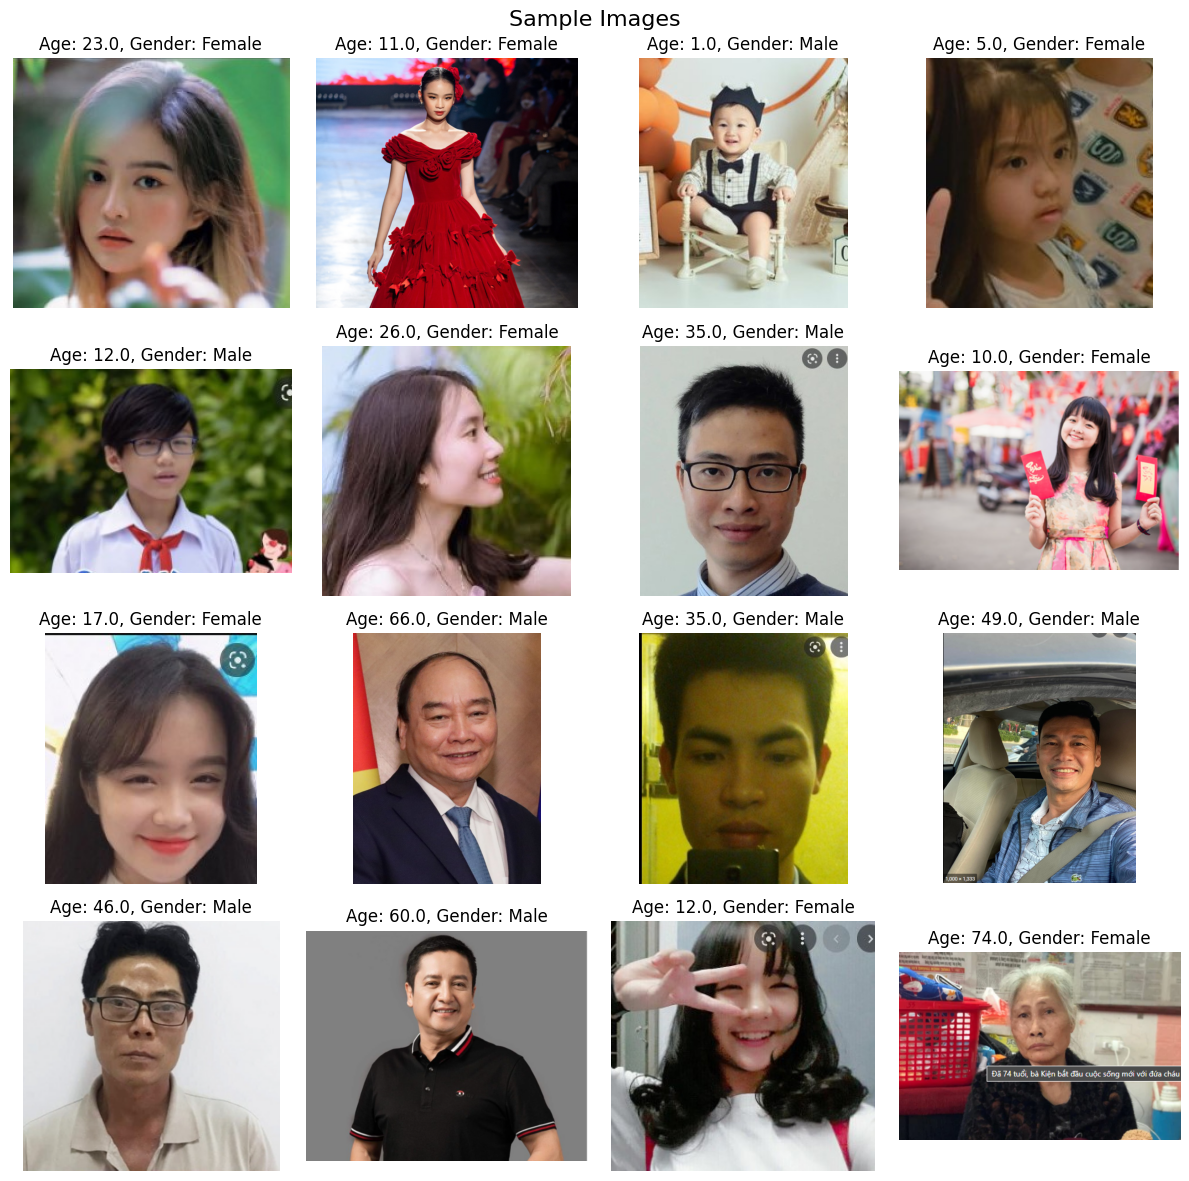

In [ ]:
# 16개 샘플 이미지 확인
num_samples = 16

# Randomly select indices
random_indices = np.random.choice(len(data), size=num_samples, replace=False)

# Create subplots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("Sample Images", fontsize=16)

# Plot each sample image
for i, idx in enumerate(random_indices):
    row = i // 4
    col = i % 4
    ax = axes[row, col]

    # Load and display image
    img_path = data.iloc[idx]['Img_path']
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off')

    # Get age and gender
    age = data.iloc[idx]['Age']
    gender = data.iloc[idx]['Gender']

    # Set title
    ax.set_title(f"Age: {age}, Gender: {gender}")

plt.tight_layout()
plt.show()

In [ ]:
# # 데이터 전처리 함수: 이미지 로드 및 전처리
# def load_and_preprocess_image(image_path):
#     image = cv2.imread(image_path)  # 이미지 로드
#     image = cv2.resize(image, (200, 200))  # 이미지 크기 조정
#     image = image.astype(np.float32) / 255.0  # 이미지 스케일링
#     return image

# # 이미지 데이터 전처리
# x_data = np.array([load_and_preprocess_image(path) for path in data['Img_path']])
# y_age = np.array(data['Age'])
# y_gender = np.array(data['Gender'])

# # 데이터 분할: 나이 예측
# x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x_data, y_age, test_size=0.2, random_state=42)
# x_train_age, x_valid_age, y_train_age, y_valid_age = train_test_split(x_train_age, y_train_age, test_size=0.2, random_state=42)

# # 데이터 분할: 성별 분류
# x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x_data, y_gender, test_size=0.2, random_state=42)
# x_train_gender, x_valid_gender, y_train_gender, y_valid_gender = train_test_split(x_train_gender, y_train_gender, test_size=0.2, random_state=42)

In [ ]:
# 데이터 전처리 함수: 이미지 로드 및 전처리
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)  # 이미지 로드
    image = cv2.resize(image, (200, 200))  # 이미지 크기 조정
    image = image.astype(np.float32) / 255.0  # 이미지 스케일링
    return image

# 이미지 데이터 전처리
x_data = np.array([load_and_preprocess_image(path) for path in data['Img_path']])
y_age = np.array(data['Age'])
y_gender = np.array(data['Gender'])

#Train Set : Validaton Set : Test Set = 6 : 2 : 2의 비율로 나누기
# 데이터 분할: 나이 예측
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x_data, y_age, test_size=0.4, random_state=42)
x_valid_age, x_test_age, y_valid_age, y_test_age = train_test_split(x_test_age, y_test_age, test_size = 0.5, random_state=42)

# 데이터 분할: 성별 분류
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x_data, y_gender, test_size=0.4, random_state=42)
x_valid_gender, x_test_gender, y_valid_gender, y_test_gender = train_test_split(x_test_gender, y_test_gender, test_size=0.5ㅊㄴ, random_state=42)

## ModelCheckpoint는 체크포인트를 저장할 때 쓰임
## EarlyStopping은 validation loss가 더 이상 개선이 없을 때 과적합을 방지하기 위해 훈련을 중단하는 용도로 쓰임

In [ ]:
#learning rate 설정
init_lr = 1e-4
epochs = 50
opt = Adam(learning_rate = init_lr
          #  , decay=init_lr / epochs)

# 과적합 방지를 위한 callback 설정
callbacks = [EarlyStopping(monitor='val_loss',
                                           patience=5),
             ModelCheckpoint(filepath='./model-{epoch:02d}-{val_loss:.2f}.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]



In [ ]:
# 모델 구성: 나이 예측 모델
# age_model
age_model = Sequential([
    Conv2D(128, kernel_size =3, input_shape=(200,200,3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(128, kernel_size =3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(256, kernel_size =3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(512, kernel_size =3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Flatten(),
    Dropout(0.25),
    Dense(512, activation  = 'relu'),
    Dense(1, activation = 'linear', name = 'age')
])

# 모델 컴파일: 나이 예측 모델
age_model.compile(loss="mse", optimizer=opt, metrics = ['mae'])

In [ ]:
# 성별 분류 모델 정의
#gender model
gender_model = Sequential([
    Conv2D(36, kernel_size=3,input_shape=(200,200,3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(64, kernel_size=3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(128, kernel_size=3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(256, kernel_size=3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Conv2D(512, kernel_size=3),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=3, strides=2),
    Flatten(),
    Dropout(0.25),
    Dense(512, activation  = 'relu'),
    Dense(1, activation = 'sigmoid', name = 'gender')
])

# 성별 분류 모델 컴파일
gender_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# # 모델 구성: 나이 예측 모델
# age_model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
#     MaxPooling2D((2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dense(1, name='age')
# ])

# # 모델 컴파일: 나이 예측 모델
# age_model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [ ]:
# # 성별 분류 모델 정의
# gender_model = Sequential([
#     Conv2D(32, (3, 3), activation='relu', input_shape=(200, 200, 3)),
#     MaxPooling2D((2, 2)),
#     Conv2D(64, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Conv2D(128, (3, 3), activation='relu'),
#     MaxPooling2D((2, 2)),
#     Flatten(),
#     Dense(64, activation='relu'),
#     Dense(1, activation='sigmoid', name='gender')
# ])

# # 성별 분류 모델 컴파일
# gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# %%time
# # 나이 예측 모델 훈련
# history_age = age_model.fit(x_train_age, y_train_age, validation_data=(x_valid_age, y_valid_age), epochs=50, batch_size=32)


Epoch 1/50
5/5 [==============================] - 14s 3s/step - loss: 841.7337 - mae: 22.8761 - val_loss: 511.0490 - val_mae: 18.4133
Epoch 2/50
5/5 [==============================] - 13s 3s/step - loss: 563.3565 - mae: 19.6453 - val_loss: 438.9890 - val_mae: 16.7919
Epoch 3/50
5/5 [==============================] - 12s 3s/step - loss: 538.2678 - mae: 19.4516 - val_loss: 498.1414 - val_mae: 18.2422
Epoch 4/50
5/5 [==============================] - 13s 3s/step - loss: 505.4948 - mae: 18.1149 - val_loss: 423.1350 - val_mae: 16.7599
Epoch 5/50
5/5 [==============================] - 12s 2s/step - loss: 469.8885 - mae: 17.4571 - val_loss: 571.8187 - val_mae: 19.7413
Epoch 6/50
5/5 [==============================] - 12s 3s/step - loss: 556.1391 - mae: 18.2245 - val_loss: 389.0825 - val_mae: 15.8246
Epoch 7/50
5/5 [==============================] - 12s 3s/step - loss: 416.9700 - mae: 16.9029 - val_loss: 358.9762 - val_mae: 14.7684
Epoch 8/50
5/5 [==============================] - 12s 2s/step 

In [ ]:
# %%time
# # 성별 분류 모델 훈련
# history_gender = gender_model.fit(x_train_gender, y_train_gender, validation_data=(x_valid_gender, y_valid_gender), epochs=50, batch_size=32)

Epoch 1/50


UnimplementedError: Graph execution error:

Detected at node binary_crossentropy/Cast defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-65-ad8a7f27b411>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/google/colab/_shell.py", line 334, in run_cell_magic

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2473, in run_cell_magic

  File "<decorator-gen-54>", line 2, in time

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magic.py", line 187, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/magics/execution.py", line 1335, in time

  File "<timed exec>", line 2, in <module>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2521, in binary_crossentropy

Cast string to float is not supported
	 [[{{node binary_crossentropy/Cast}}]] [Op:__inference_train_function_9357]

In [ ]:
%%time
# age_model 학습
history_age = age_model.fit(x_train_age, y_train_age,
                        validation_data=(x_valid_age, y_valid_age), batch_size = 32, epochs=50, callbacks = callbacks)

In [ ]:
%%time
# gender_model 학습
history_gender = gender_model.fit(x_train_gender, y_train_gender,
                        validation_data=(x_valid_gender, y_valid_gender), batch_size=32, epochs=50, callbacks = callbacks)

In [ ]:
age_model.save('age_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [ ]:
gender_model.save('gender_model.h5')

In [ ]:
from google.colab import files

files.download('age_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

files.download('gender_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
history_age

In [ ]:
# 나이 예측 모델 평가
loss_age, mae_age = age_model.evaluate(x_test_age, y_test_age)

# 성별 분류 모델 평가
loss_gender, accuracy_gender = gender_model.evaluate(x_test_gender, y_test_gender)

print(f'Age Model - Test Loss: {loss_age}, MAE: {mae_age}')
print(f'Gender Model - Test Loss: {loss_gender}, Accuracy: {accuracy_gender}')

2/2 [==============================] - 1s 344ms/step - loss: 903.1426 - mae: 25.2489


UnimplementedError: Graph execution error:

Detected at node binary_crossentropy/Cast defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-70-c7e1035a5968>", line 5, in <cell line: 5>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2296, in evaluate

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 4108, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2066, in test_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2049, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2037, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1919, in test_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2521, in binary_crossentropy

Cast string to float is not supported
	 [[{{node binary_crossentropy/Cast}}]] [Op:__inference_test_function_9701]

In [ ]:
history = history_age
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Age model Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,300)
plt.legend()
plt.show()

In [ ]:
history = history_gender
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Gender Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 여기서 loss란  결과 값과 예측 값의 차이를 나타내는 손실 값을 뜻하므로 loss가  작을수록 좋은 모델이 될 수 있습니다.

### training loss는 지속적으로 감소하고 있고, validation loss는 감소하다가 어느 순간부터 증가하는 추세로 바뀐 것을 확인할 수 있습니다.
### 이는 epoch가 증가할수록 train dataset에 딱 맞는 정답을 학습하려고 하기 때문에 validation에서는 오히려 성능 저하를 보이는 과적합이라고 볼 수 있습니다.
### 따라서 학습 곡선을 확인해가며 모델을 구축하는 것이 중요합니다.

In [ ]:
len(x_test_age)

In [ ]:
y_test_age[0]

In [ ]:
age_preds = age_model.predict(x_test_age)

In [ ]:
gender_preds = gender_model.predict(x_test_gender)

In [ ]:
from sklearn.metrics import mean_absolute_error, accuracy_score, recall_score, precision_score, confusion_matrix, classification_report

In [ ]:
age_mae = mean_absolute_error(y_test_age, age_preds)

age_mae

In [ ]:
gender_accuracy = accuracy_score(y_test_gender, np.round(gender_preds))

gender_accuracy

In [ ]:
plt.hist(gender_preds.ravel())

In [ ]:
print(classification_report(y_test_gender,np.round(gender_preds)))

In [ ]:
confusion_matrix(y_test_gender,np.round(gender_preds))

# Test Set에서 랜덤으로 16개의 사진만 출력하고, 사진 상단에는 실제 정답, 하단에는 예측한 값 표기하기

In [ ]:
import math
n=16
random_indices = np.random.choice(len(x_test_age), size=n)
n_cols = 4
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 17))
for i, x in enumerate(random_indices):
   ax = axes.flat[i]
   ax.imshow(x_test_age[x])
   real_age = y_test_age[x]
   predict_age = age_preds[x]
   if y_test_gender[x] == 1:
     real_gender = 'female'
   else:
     real_gender = 'male'
   if np.round(gender_preds[x]) == 1:
     predict_gender = 'female'
   else:
     predict_gender ='male'
   ax.set_title('real_age: {}, real_gender: {}'.format(int(real_age),real_gender))
   ax.set_xlabel('predict_age: {}, predict_gender: {}'.format(int(predict_age),predict_gender))
   ax.xaxis.label.set_color('red')


In [ ]:
# import math
# n = 16
# random_indices = np.random.choice(len(x_test_age), size=n)
# n_cols = 4
# n_rows = math.ceil(n / n_cols)
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 17))
# for i, x in enumerate(random_indices):
#    ax = axes.flat[i]
#    ax.imshow(x_test_age[x])
#    real_age = y_test_age[x]
#    if y_test_gender[x] == 1:
#      real_gender = 'female'
#    else:
#      real_gender = 'male'
#    ax.set_title('Real Age: {}, Real Gender: {}'.format(int(real_age), real_gender))
#    ax.set_xlabel('Predicted Age: {}, Predicted Gender: {}'.format(int(age_preds[x]), 'Female' if gender_preds[x] >= 0.5 else 'Male'))
#    ax.xaxis.label.set_color('red')

# # Hide empty subplots
# for j in range(i+1, n):
#     axes.flat[j].axis('off')

# plt.tight_layout()
# plt.show()

# 모델을 저장하고 PC에도 저장해주기

In [ ]:
gender_model.save('gender_model.h5')
age_model.save('age_model.h5')

from google.colab import files
files.download('gender_model.h5')
files.download('age_model.h5')



---



# OPENCV를 이용한 얼굴 인식하기
- 새로운 이미지를 통한 나이/성별
- 얼굴 인식은 OPENCV의 CascadeClassifier를 사용하여 쉽게 검출할 수 있음


### 이미지로 예측하기

In [ ]:
#라이브러리 import
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

#model load
age_model_path = "./age_model.h5"
gender_model_path = './gender_model.h5'

age_model = load_model(age_model_path)
gender_model = load_model(gender_model_path)

#얼굴 검출을 위한 OPENCV Cascadeclassifier load
face_cascade = cv2.CascadeClassifier("./haarcascade_frontalface_default.xml")

age_ = []
gender_ = []

image_size = 200

pic = cv2.imread('./son_heung_min.jpg')
faces = face_cascade.detectMultiScale(pic,scaleFactor=1.11, minNeighbors=8)
age_ = []
gender_ = []
for (x,y,w,h) in faces:
    img = pic[y:y + h, x:x + w]
    img = cv2.resize(img,(image_size,image_size))
    age_predict = age_model.predict(np.array(img).reshape(-1,image_size,image_size,3))
    gender_predict = gender_model.predict(np.array(img).reshape(-1,image_size,image_size,3))
    age_.append(age_predict)
    gender_.append(np.round(gender_predict))
    gend = np.round(gender_predict)
    if gend == 0:
        gend = 'Man'
        col = (255,255,0)
    else:
        gend = 'Woman'
        col = (203,12,255)
    cv2.rectangle(pic,(x,y),(x+w,y+h),(0,225,0),1)
    cv2.putText(pic,"Age:"+str(int(age_predict))+" / "+str(gend),(x,y-5),cv2.FONT_HERSHEY_SIMPLEX,w*0.005,col,1)
pic1 = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,16))
print(age_,gender_predict)
plt.imshow(pic1)
plt.show()

### 영상으로 예측하기

In [ ]:
# 영상 불러오기
video = cv2.VideoCapture('./korea_amatch_soccer.mp4')

#while문을 사용하여 특정 조건이 만족될 때까지 계속 실행

while True:
    ret, frame = video.read()
    faces = face_cascade.detectMultiScale(frame,scaleFactor=1.11, minNeighbors=8)

    age_ = []
    gender_ = []
    for (x,y,w,h) in faces:
        img = frame[y:y + h, x:x + w]
        img = cv2.resize(img,(image_size,image_size))
        age_predict = age_model.predict(np.array(img).reshape(-1,image_size,image_size,3))
        gender_predict = gender_model.predict(np.array(img).reshape(-1,image_size,image_size,3))
        age_.append(age_predict)
        gender_.append(np.round(gender_predict))
        gend = np.round(gender_predict)
        if gend == 0:
            gend = 'Man'
            col = (255,255,0)
        else:
            gend = 'Woman'
            col = (203,12,255)
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,225,0),1)
        cv2.putText(frame,"Age:"+str(int(np.round(age_predict)))+" / "+str(gend),(x,y-5),cv2.FONT_HERSHEY_SIMPLEX,w*0.005,col,1)
    cv2.imshow("camera",frame)

    key = cv2.waitKey(10)
    # 자판의 ESC키가 27, ESC 입력시 비디오창 종료
    if key == 27:
        cv2.destroyAllWindows()
        break

### 웹캠으로 실시간 예측하기
- 동영상으로 예측하는 것과 방식은 동일하지만 cv2.VideoCapture()에서 파일 경로를 지정해 주지 않고, 0으로 설정해 주게 되면 내장된 웹캠이 작동

In [ ]:
# 웹캠불러오기
camera = cv2.VideoCapture(0)

#while문을 사용하여 특정 조건이 만족될 때까지 계속 실행

while True:
    ret, frame = camera.read()
    faces = face_cascade.detectMultiScale(frame,scaleFactor=1.11, minNeighbors=8)

    age_ = []
    gender_ = []
    for (x,y,w,h) in faces:
        img = frame[y:y + h, x:x + w]
        img = cv2.resize(img,(image_size,image_size))
        age_predict = age_model.predict(np.array(img).reshape(-1,image_size,image_size,3))
        gender_predict = gender_model.predict(np.array(img).reshape(-1,image_size,image_size,3))
        age_.append(age_predict)
        gender_.append(np.round(gender_predict))
        gend = np.round(gender_predict)
        if gend == 0:
            gend = 'Man'
            col = (255,255,0)
        else:
            gend = 'Woman'
            col = (203,12,255)
        cv2.rectangle(frame,(x,y),(x+w,y+h),(0,225,0),1)
        cv2.putText(frame,"Age:"+str(int(np.round(age_predict)))+" / "+str(gend),(x,y-5),cv2.FONT_HERSHEY_SIMPLEX,w*0.005,col,1)
    cv2.imshow("camera",frame)

    key = cv2.waitKey(10)
    # 자판의 ESC키가 27, ESC 입력시 비디오창 종료
    if key == 27:
        cv2.destroyAllWindows()
        break